In [ ]:
# GNU LESSER GENERAL PUBLIC LICENSE
#                       Version 3, 29 June 2007
# Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>
# Everyone is permitted to copy and distribute verbatim copies
# of this license document, but changing it is not allowed.

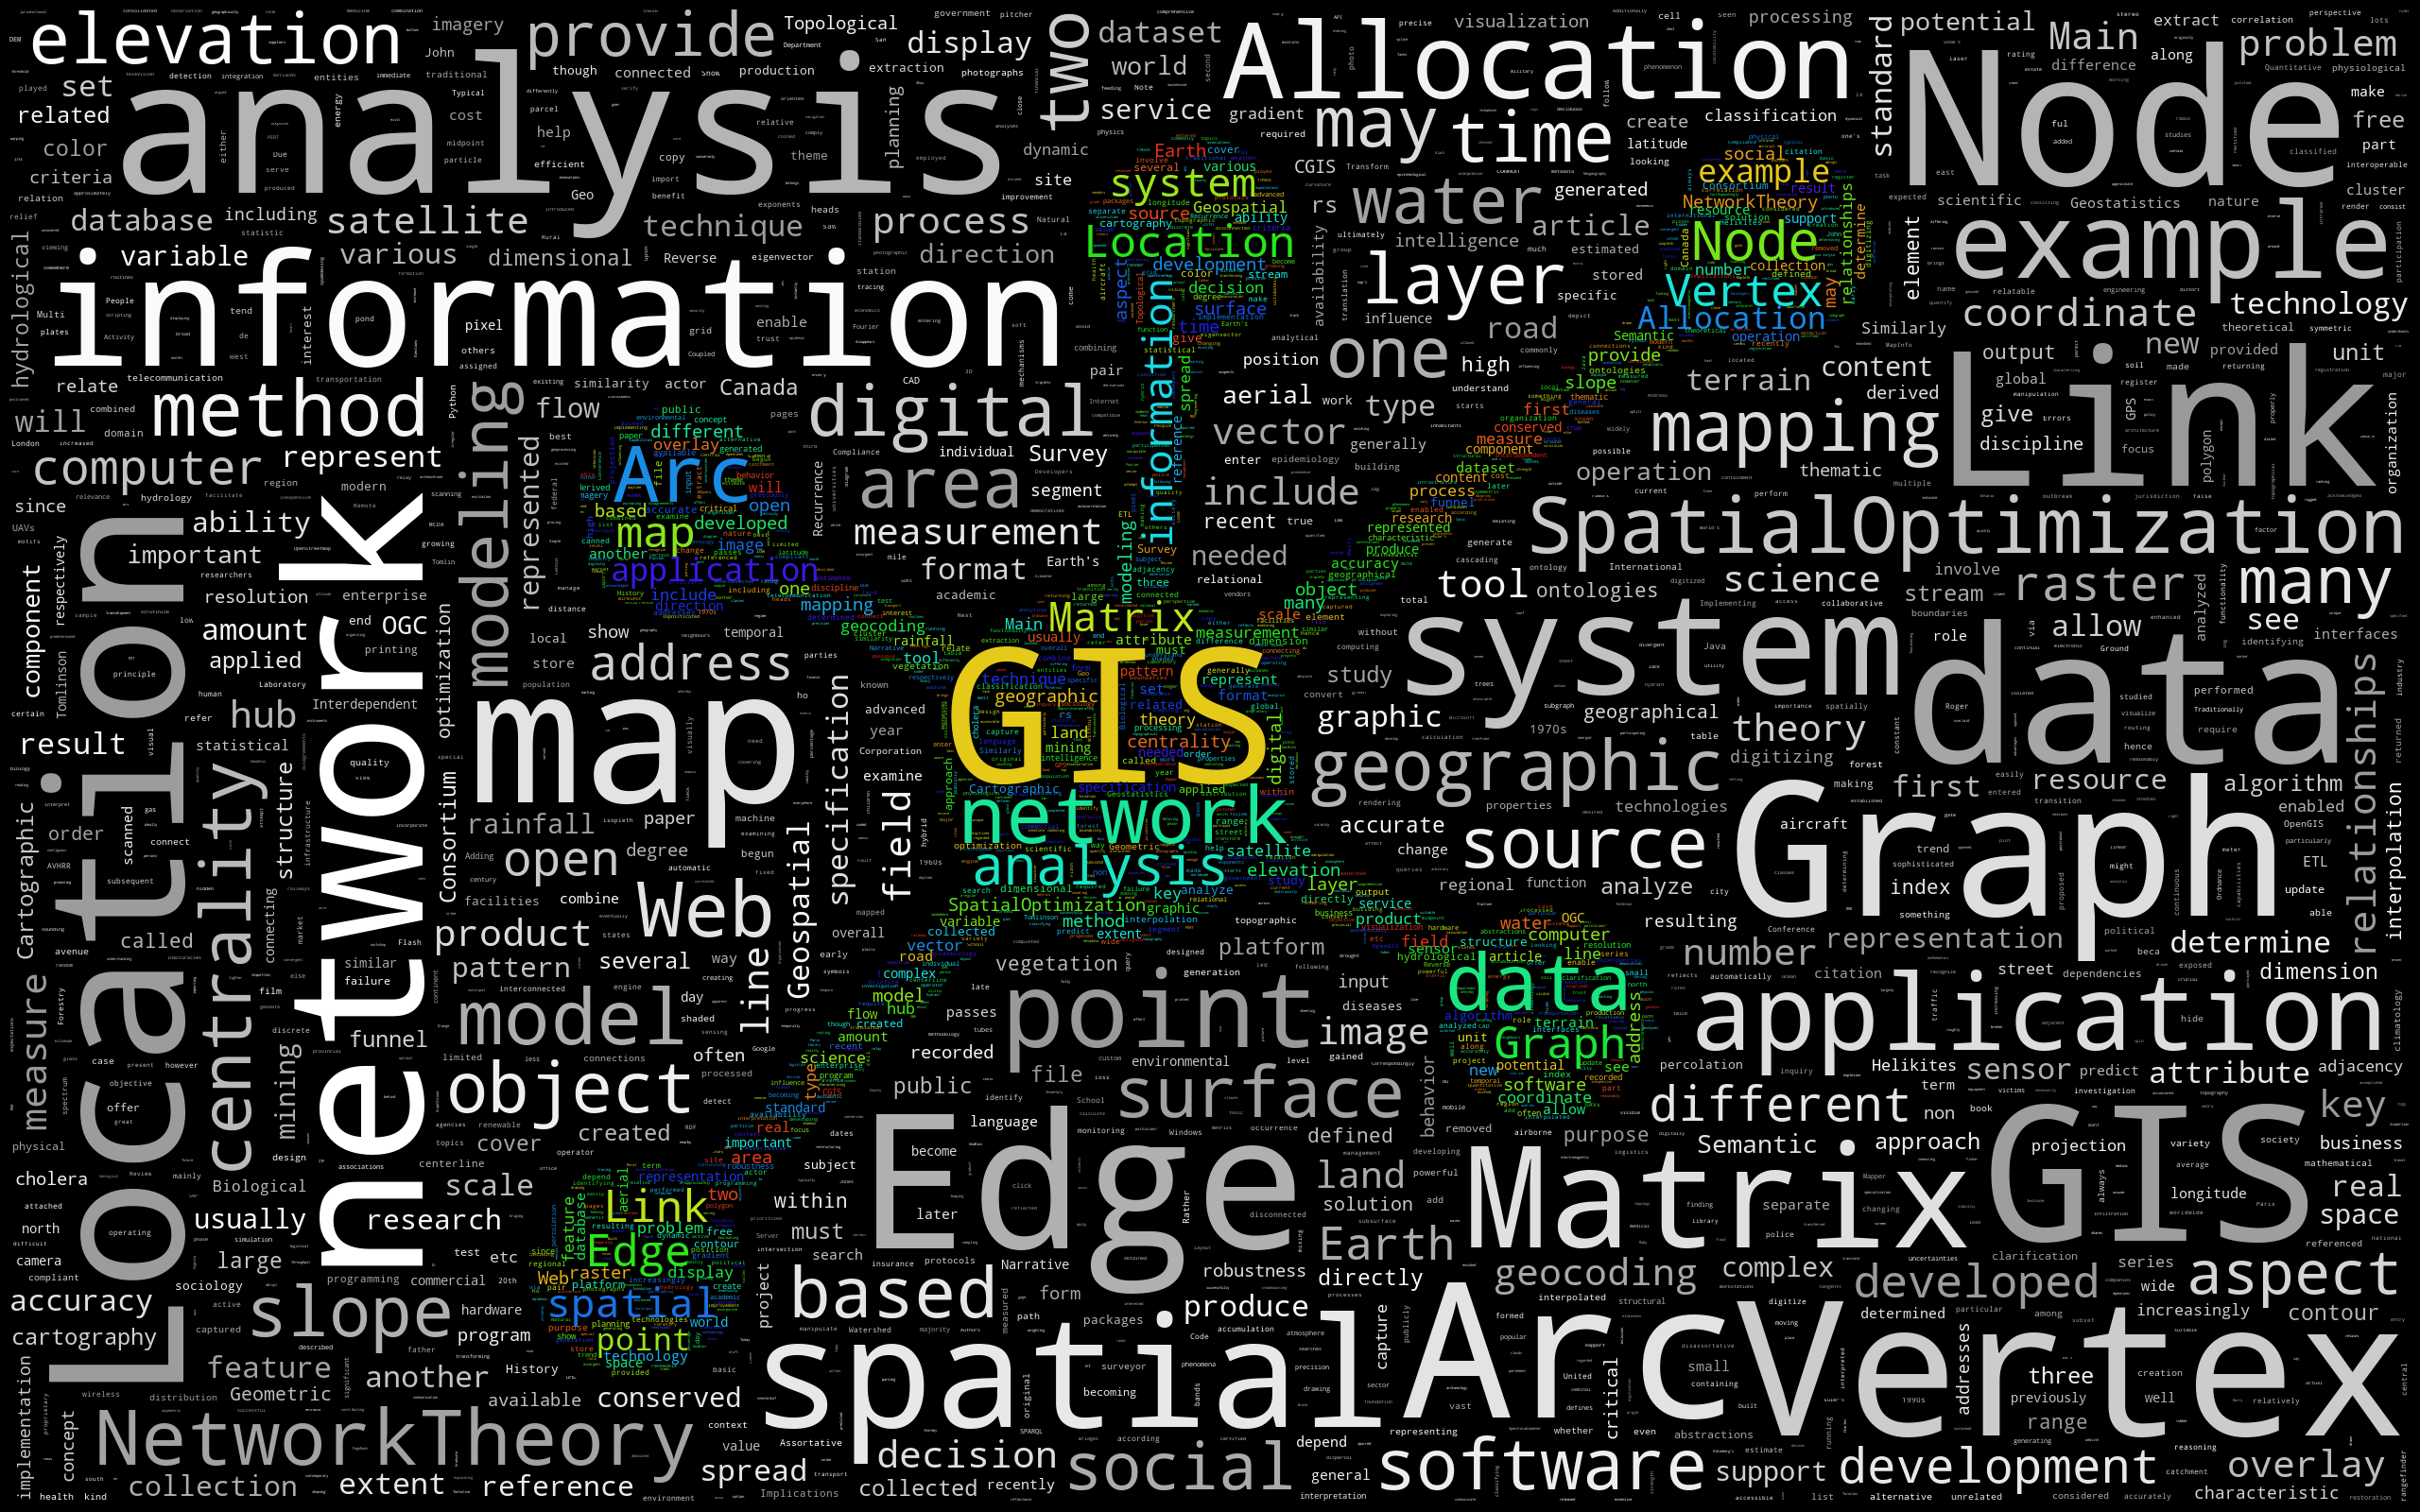

In [1]:
import IPython.display as IPd
import os
path = os.path.dirname(".")
graphics_path = path + "Graphics/"
data_path_in =  path + "Data_In/"
data_path_out =  path + "Data_Out/"
session = IPd.Image(graphics_path+"/logo.png")
session

# $$\text{Automated GISci for Network-based Decisions}$$
# $$\text{Association of American Geographers}$$
## $$\text{Boston 2017}$$

------------------------

# $$\text{An Out-of-Core Computational Approach to the Transportation Problem}$$

## $$ \begin{array}{lcl}
\text{James D. Gaboardi}  & \cdot & \text{Florida State University}\\
\end{array}
$$

The Transportation Problem, which is also known as the Transportation Simplex or the 
Transshipment Problem, seeks to allocate supply to demand while minimizing transportation
costs and was formally described by Hitchcock (1941). Supply ($n$) and demand ($m$) are
generally represented as unit weights of decision variables at facilities along a network with
the time or distance between nodes representing the cost of transporting one unit from a
supply node to a demand node. These costs are stored in an $n$ x $m$ cost matrix. The
Transportation Problem has continued to garner attention through to the present in multiple
academic disciplines with Spatial Optimization in Geography being one of these at the
forefront. As the processing power of computers has improved over the years, the capabilities
of mathematical programming software to solve these problems have also improved.
However, one of the main roadblocks is the need to store the ever-larger cost and decision
variable matrices in memory while building and solving the optimization model. This paper
seeks to provide a solution to the issue, not by modifying the structure of the problem or
proposing a new algorithm, but by tackling the memory bottleneck with out-of-core storage.
This will be attempted in an object-oriented programming language environment primarily
utilizing two Python packages: dask (a parallel computing library) and pulp (an integer and
mixed-integer programing library).

---------------------

# $ \text{Overview}$
* $\text{The Transportation Problem}$
* $\text{Non-Spatial Simulations}$
* $\text{Emprical, Spatial Simulation}$
* $\text{RAM Disparity}$
* $\text{Gurobi/Numpy \Longrightarrow }$
    * $\text{parallel processing in the HPC cluster?}$

------------------

## $\text{The Transportation Problem: Integer Programming Formulation}$

---

### $\text{Primal: minimize the cost needed to ship units from supply facilities to demand facilities.}$
---

## $$ \begin{array}{rllllll}
 \text{min}  & \displaystyle \sum_{i \in I} \sum_{j \in J} c_{ij} sd_{ij}&&&&&         \\
 \text{s.t.} & \displaystyle \sum_{j \in J} sd_{ij} = S_i &\text{or}&\sum_{j \in J} sd_{ij} >= S_i& \text{or}&\sum_{j \in J} sd_{ij} <= S_i& \forall i \in I \\
             & \displaystyle \sum_{i \in I} sd_{ij} = D_j &\text{or}&\sum_{i \in I} sd_{ij} <= D_j& \text{or}&\sum_{i \in I} sd_{ij} >= D_j& \forall j \in J \\
             & \displaystyle sd_{ij} \geq 0     &&&&& \forall i \in I, \forall j \in J \\
\end{array}
$$

### $$ \begin{array}{rllllll}
 \text{where}&\\
             & \scriptsize{i = \text{a specific origin}} \\
             & \scriptsize{j = \text{a specific destination}} \\
             & \scriptsize{I = \text{the set of origins}} \\
             & \scriptsize{J = \text{the set of destinations}} \\
             & \scriptsize{a_{i} = \text{demand weight at each node}} \\
             & \scriptsize{c_{ij} = \text{travel costs between nodes}} \\
             & \scriptsize{sd_{ij} = \text{shipping decision variable from } i \text{ to } j} \\
             & \scriptsize{S_{i} = \text{units of supply from facility } i} \\
             & \scriptsize{D_{j} = \text{units of demand by facility } j} \\
\end{array}
$$

-----

Originally published:
- ***Hitchcock, Frank L. 1941***. The Distribution of a Product from Several Sources to Numerous Localities. *Journal of Mathematics and Physics*. 20(1):224-230.

Adapted from:
- ***Daskin, Mark. S. 1995***. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

---

### Our goal is to be able to:

1. Solve a Balanced 50,000 x 50,000 Transportation Problem with simulated data;
2. Solve a network-based Balanced 50,000 x 50,000 Transportation Problem with simulated data;
3. Solve a network-based very large Transportation Problem with empircal data (potentially Atlanta,GA)

#### Ideally, this will all be done without altering the structure of the Transportation Problem by utilizing  `python` packages like `dask`

-----

# $\text{Import Packages and Declare Constants}$

In [95]:
import dask
import geopandas as gpd
import pysal as ps
import dask.array as da
import gurobi as grb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import operator
import pandas as pd
import psutil
import platform
from shapely.geometry import Point
from shapely.geometry import LineString
import sys
import time

% matplotlib inline

mpl.rcParams['figure.figsize'] = 15,15

GB = 1073741824.0005517                                                # Bytes to gigabytes
operators = {"==": operator.eq, "<=": operator.le, ">=": operator.ge}  # mathematical operators dictionary
methods = {"auto":-1, "primal simplex":0, "dual simplex":1,            # algorithm dictionary
           "barrier":2, "concurrent":3, "deterministic concurrent":4}

In [132]:
def transportation_simplex(r_dim, c_dim, seed=1, relaxed=False, simulated_costmatrix=None,
                           costmatrix=None,
                           simulated_sd="lowhigh", write_lp=True, name=None, output=1, mipfocus=2,
                           method=methods["auto"], timelimit=None):
    """
    Solve the Transportation Simplex in Gurobi
    
    Parameters
    ==========
    r_dim                  int
                           Row dimension of the cost matrix.
    c_dim                  int
                           Column dimension of the cost matrix.
    seed                   int
                           Seed for psuedo-random number generation.
    relaxed                bool
                           Relaxation of the supply and demand constraints.
                           Default is False.
    simulated_costmatrix   list, tuple
                           Low and high for pseudo-random integer generation
                           for cost matrix from each i to each j. Default
                           is [1,10].
    simulated_sd           str
                           Simulated supply and demand vectors.
                           `balanced`, `lowhigh`, `highlow`. Default is `lowhigh`.
    write_lp               bool
                           Write out a linear programming file (True) in 
                           IBM Cplex format. Directory path must be a predefined 
                           variable. Default is True.
    name                   str
                           Name of the problem for model object and LP file.
                           Default is None.
    output                 int
                           Print out solution progress `1`. 
                           Hide solution progress `0`. Default in `1`.
    mipfocus               int
                           Solution focus. `1` for focus on feasibility. `2`
                           for focus on proven optimality. `3` for focus on moving 
                           the best objective bound. Default is `2`.
    method                 str
                           Algorithms defined in the `methods` dictionary.
                           Gurobi takes an int. Default is 
                           >>> {"auto":-1, "primal simplex":0,
                                "dual simplex":1, "barrier":2, 
                                "concurrent":3, "deterministic concurrent":4}
    timelimit              int
                           Time limit in seconds to solve the Transportation Problem.
                           Default is None.
    Returns
    =======
    decisions              pandas.DataFrame
                           Dataframe of decision variables and values
    cm                     numpy.array
                           `r_dim` x `c_dim` array of i,j costs
    total_time             float
                           Total time to instantiate model and solve                  
    """
    def _get_supply_constrs(m, oper="=="):
        """
        Parameters
        ==========
        m      gurobi.Model
               Instantiated mathematical programming model
        oper   str
               Mathematical operator as decided by the relaxation constraint and
               sums of supply/demand. Default is `==`.
        Returns
        =======
        transportation problem supply constraints
        """
        oper = operators[oper]
        m.addConstrs((oper(decision_variables.sum(origin,'*')\
                                   - supply[origin], 0)\
                                   for origin in row_range),
                                   "Supply")
        return m 
    
    def _get_demand_constrs(m, oper="=="):
        """
        Parameters
        ==========
        m      gurobi.Model
               Instantiated mathematical programming model
        oper   str
               Mathematical operator as decided by the relaxation constraint and
               sums of supply/demand. Default is `==`.
        Returns
        =======
        transportation problem demand constraints
        """
        oper = operators[oper]
        m.addConstrs((oper(decision_variables.sum('*',destination)\
                                            - demand[destination], 0)\
                                           for destination in column_range),
                                           "Demand")
        return m 
    
    time_start = time.time()
    np.random.seed(seed)
    row_range, column_range = range(r_dim), range(c_dim)
    if costmatrix != None:
        cm = costmatrix
    if simulated_costmatrix:
        cm = np.random.randint(simulated_costmatrix[0],
                               simulated_costmatrix[1],
                               (r_dim,c_dim)).astype(float)
    if not simulated_sd:
        pass
    if simulated_sd:
        sl, sh, dl, dh = 10, 100, 10, 100
        if simulated_sd == "balanced":
            supply = np.random.randint(sl, sh, (r_dim,1)).astype(float)
            equal_sum = False
            while not equal_sum:
                demand = np.random.randint(dl, dh, (c_dim,1)).astype(float)
                if demand.sum() == supply.sum():
                    equal_sum = True
        if simulated_sd == "lowhigh":
            supply = np.random.randint(sl,sh*2,(r_dim,1)).astype(float)
            demand = np.random.randint(dl,dh,(c_dim,1)).astype(float)
        if simulated_sd == "highlow":
            dl, dh, sl, sh = sl, sh, dl, dh
            supply = np.random.randint(sl,sh,(r_dim,1)).astype(float)
            demand = np.random.randint(dl,dh*2,(c_dim,1)).astype(float)
    
    var_names = pd.DataFrame(np.array(["sd["+str(r)+","+str(c)+"]"\
                                   for r in row_range\
                                   for c in column_range]).reshape(r_dim,c_dim),
                                   index=['s'+str(r) for r in row_range],
                                   columns=['d'+str(c) for c in column_range])
    transportation_simplex = grb.Model(name)
    transportation_simplex.Params.OutputFlag = output
    transportation_simplex.setParam('MIPFocus', mipfocus)
    transportation_simplex.Params.method = method
    transportation_simplex.setParam('TimeLimit', timelimit)
    decision_variables = transportation_simplex.addVars(r_dim,
                                                        c_dim,
                                                        vtype=grb.GRB.CONTINUOUS,
                                                        obj=cm,
                                                        name="sd")
    # Set Supply and Demand Constraints
    if not relaxed:
        _get_supply_constrs(transportation_simplex)
        _get_demand_constrs(transportation_simplex)
    if relaxed and supply.sum() >= demand.sum():
        _get_supply_constrs(transportation_simplex, oper="<=")
        _get_demand_constrs(transportation_simplex, oper=">=")
    if relaxed and supply.sum() <= demand.sum():
        _get_supply_constrs(transportation_simplex, oper=">=")
        _get_demand_constrs(transportation_simplex, oper="<=")
    # Set Objective Function
    """
    transportation_simplex.setObjective(grb.quicksum(decision_variables[origin,destination].Obj\
                                    * decision_variables[origin,destination] 
                                    for origin in row_range 
                                    for destination in column_range))
    """
    cm_dict = {(row,column):cm[row][column] for row in row_range\
                                            for column in column_range}
    transportation_simplex.setObjective(decision_variables.prod(cm_dict))
    
    # Solve
    transportation_simplex.optimize()
    # Write LP Function
    if write_lp:
        transportation_simplex.write(data_path_out+name+".lp")
    # Record Solution Variables
    try:
        decisions = pd.DataFrame([[var.VarName, var.X]\
                                 for var in transportation_simplex.getVars()\
                                   if var.X > 0], columns=['Decision_Variable_Name',
                                                           'Decision_Variable_Value'])
    except:
        decisions = pd.DataFrame()
    total_time = round(time.time() - time_start, 5)/60.
    return decisions, cm, total_time

In [115]:
def solution_info(variables, matrix, time_):
    """
    Parameter
    =========
    variables
    matrix
    time_
    Returns
    =======
    """
    matrix_size = sys.getsizeof(matrix)/GB
    print "*************************************************************"
    print "Cost Matrix Size (GB):\t\t\t", matrix_size
    print "Real Time Build & Solve (sec):\t\t", time_
    print "*************************************************************"
    print variables.head()

# $2,2 \text{ cost matrix: low supply, high demand w/ relaxed constraints}$

In [129]:
sv, cm, rt = transportation_simplex(2, 2, seed=2,
                                    relaxed=True,
                                    simulated_costmatrix=[1,10],
                                    simulated_sd="lowhigh",
                                    name="TransportationProblem",
                                    output=1,
                                    mipfocus=2,
                                    method=methods["primal simplex"],
                                    timelimit=1)
solution_info(sv, cm, rt)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 4  Default: -1
Changed value of parameter TimeLimit to 1.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4 rows, 4 columns and 8 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+02]
Presolve time: 0.01s
Presolved: 4 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.100000e+01   3.999972e+06      0s
       2    2.5100000e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.03 seconds
Optimal objective  2.510000000e+02
*************************************************************
Cost Matrix Size (GB):			1.34110450745e-07
Real Time Build &

/Users/jgaboardi/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


# $20,20 \text{ cost matrix: balanced supply and demand w/ exact constraints}$

In [99]:
sv, cm, rt = transportation_simplex(20, 20, seed=2,
                                    relaxed=False,
                                    simulated_costmatrix=[1,10],
                                    simulated_sd="balanced",
                                    name="TransportationProblem",
                                    output=0,
                                    mipfocus=2,
                                    method=methods["primal simplex"],
                                    timelimit=1)
solution_info(sv, cm, rt)

*************************************************************
Cost Matrix Size (GB):			3.08454036712e-06
Real Time Build & Solve (sec):		0.0006115
*************************************************************
  Decision_Variable_Name  Decision_Variable_Value
0               sd[0,19]                     42.0
1                sd[1,6]                      9.0
2                sd[1,7]                     28.0
3               sd[1,14]                     33.0
4               sd[1,17]                     25.0


/Users/jgaboardi/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:133: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


# $200,200 \text{ cost matrix: high supply, low demand w/ relaxed constraints}$

In [52]:
sv, cm, rt = transportation_simplex(200, 200, seed=2,
                                    relaxed=True,
                                    simulated_costmatrix=[1,10],
                                    simulated_sd="highlow",
                                    name="TransportationProblem",
                                    output=0,
                                    mipfocus=2,
                                    method=methods["primal simplex"],
                                    timelimit=1)
solution_info(sv, cm, rt)

/Users/jgaboardi/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:133: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


*************************************************************
Cost Matrix Size (GB):			0.000298127532005
Real Time Build & Solve (sec):		0.0280718333333
*************************************************************
  Decision_Variable_Name  Decision_Variable_Value
0               sd[0,27]                     50.0
1              sd[0,100]                      1.0
2                sd[1,5]                     70.0
3                sd[2,0]                     68.0
4                sd[3,7]                      9.0


# $2000,2000 \text{ cost matrix}$

In [8]:
sv, cm, rt = transportation_simplex(2000, 2000, seed=2,
                                    relaxed=True,
                                    simulated_costmatrix=[1,10],
                                    simulated_sd="lowhigh",
                                    name="TransportationProblem",
                                    output=0,
                                    mipfocus=2,
                                    method=methods["primal simplex"],
                                    timelimit=1)
solution_info(sv, cm, rt)

/Users/jgaboardi/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:98: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


*************************************************************
Cost Matrix Size (GB):			0.0298024266958
Real Time Build & Solve (sec):		3.0490605
*************************************************************


/Users/jgaboardi/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:133: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


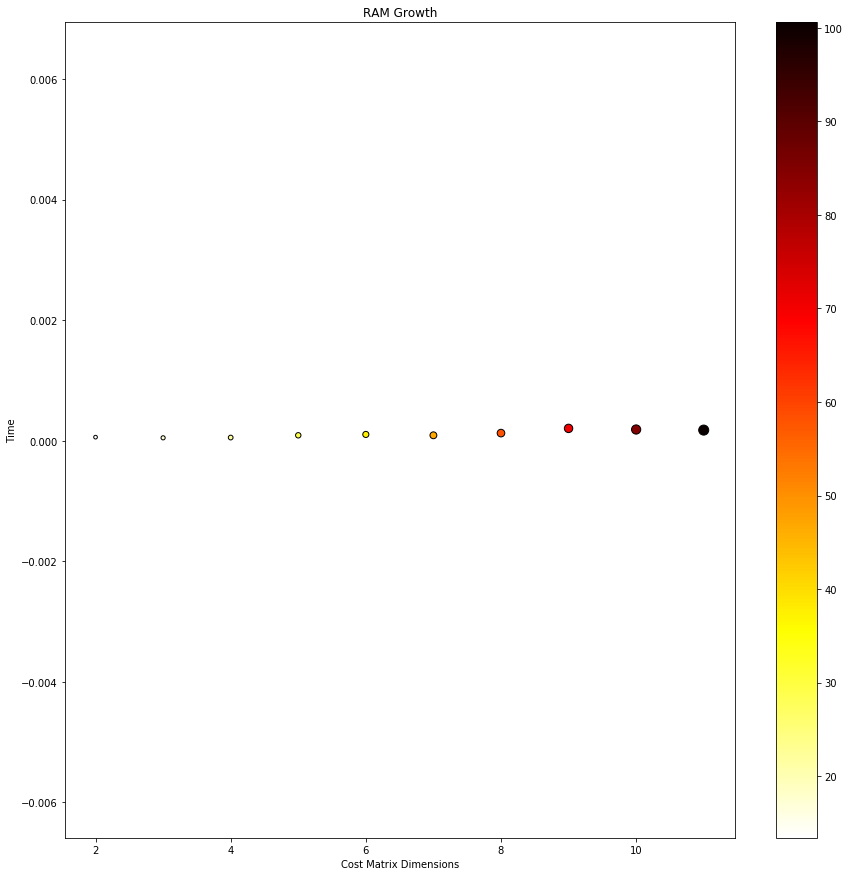

In [101]:
cm_sizes = []
iter_times = []
iterations = range(2,12,1)
for dim in iterations:
    sv, cm, rt = transportation_simplex(dim, dim, seed=2,
                                        relaxed=True,
                                        simulated_costmatrix=[1,10],
                                        simulated_sd="lowhigh",
                                        name="TransportationProblem",
                                        output=0,
                                        mipfocus=2,
                                        method=methods["primal simplex"],
                                        timelimit=1)
    cm_size = sys.getsizeof(cm)/GB
    cm_sizes.append(cm_size)
    iter_times.append(rt)
plotter = pd.DataFrame()
plotter['dims'] = iterations
plotter['cm_size'] = cm_sizes
plotter['iter_time'] = iter_times
fig = plt.figure()
ax = fig.add_subplot(111,alpha=.15)
AX = ax.scatter(plotter.dims,
           plotter.iter_time,
           c=plotter.cm_size*100000000,
           cmap="hot_r",
           s=plotter.cm_size*100000000,
           edgecolor="k")                
fig.colorbar(AX)
ax.set_title("RAM Growth")
ax.set_xlabel('Cost Matrix Dimensions')
ax.set_ylabel('Time')
plt.show()

# $ \text{ Empirical Network Subset}$
### $ \text{Waverly Hills, Tallahassee, Florida}$

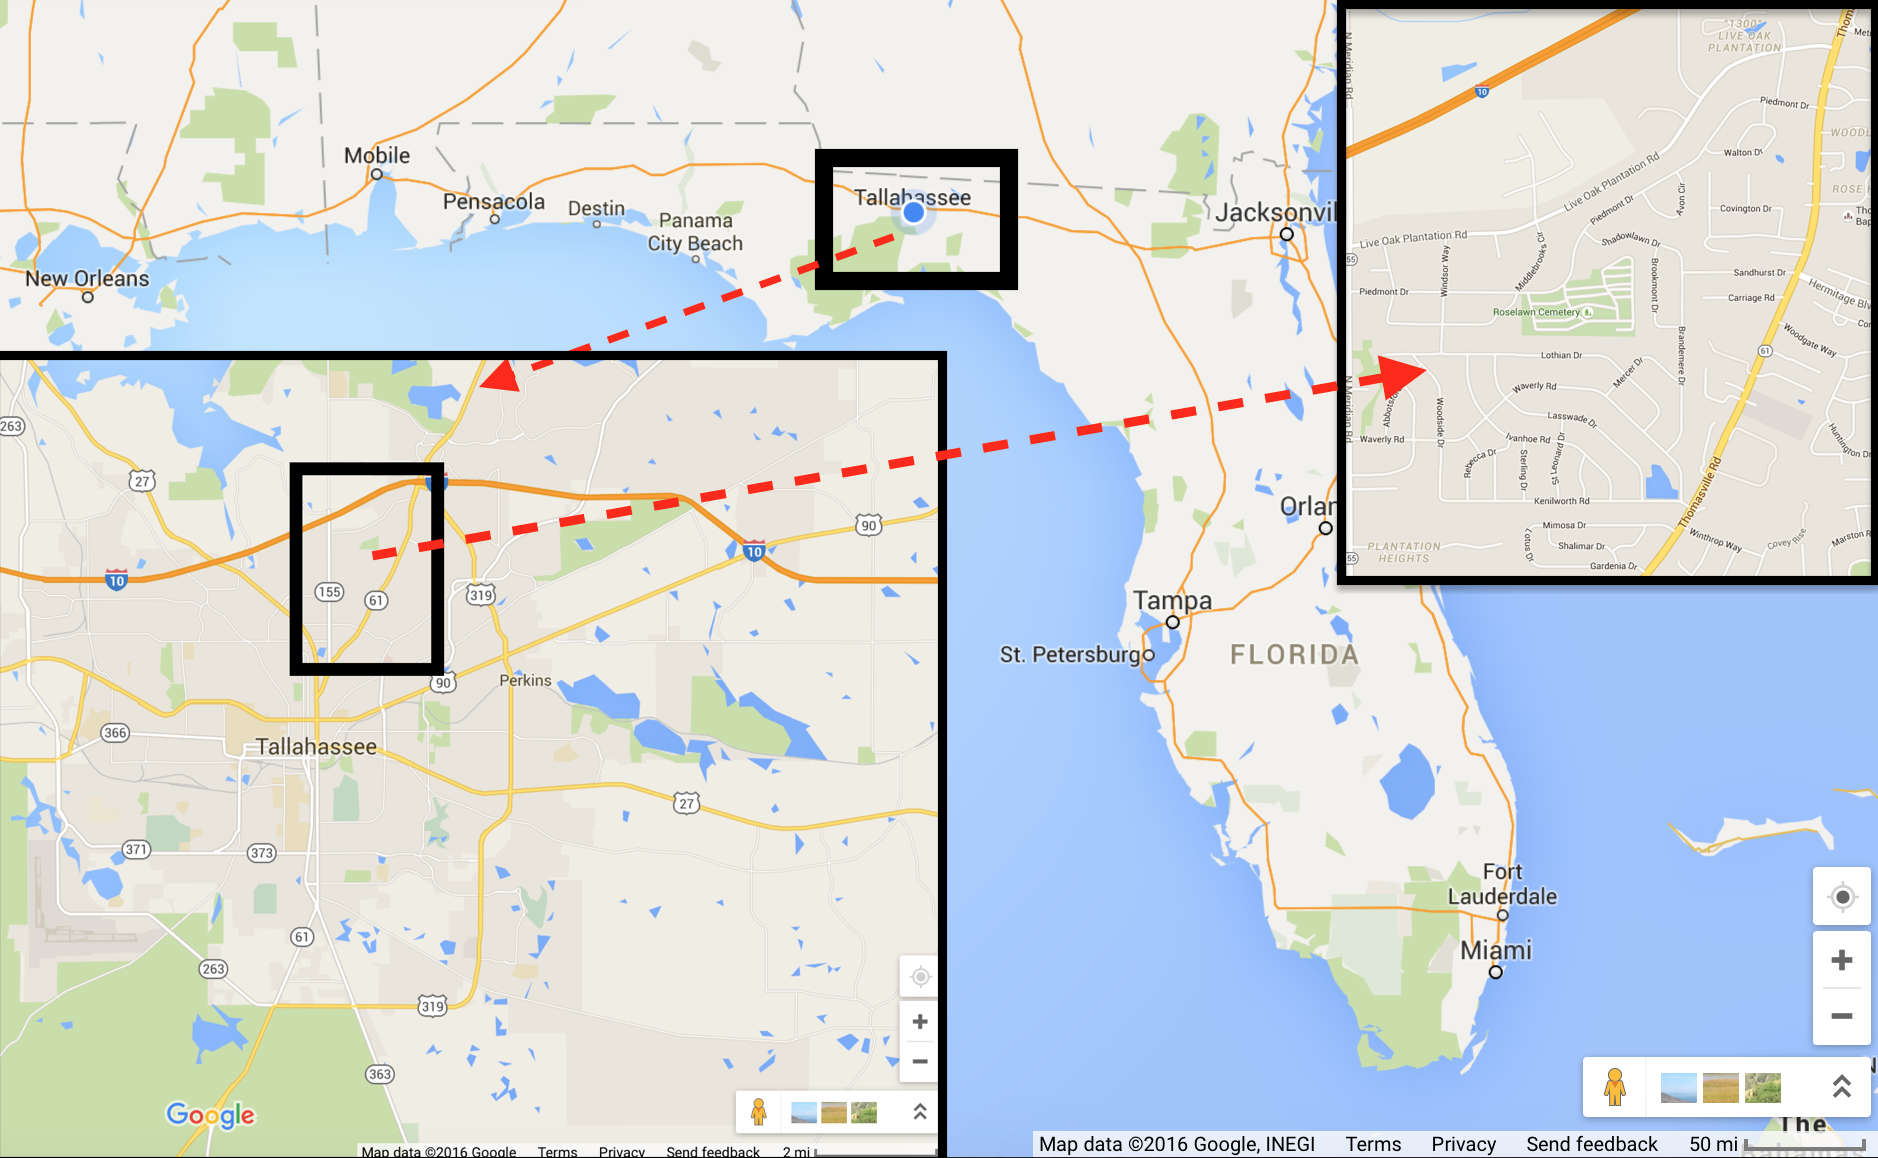

In [54]:
FLTallWav = IPd.Image(graphics_path+"/FLTallWav.png", width=1200, height=600)
FLTallWav

In [102]:
def get_streets_buffer(street_file, buff=50):
    """
    """
    b1 = street_file.buffer(buff)  #Buffer
    ub = b1.unary_union  #Buffer Union
    b2 = gpd.GeoSeries(ub)
    out_buff = gpd.GeoDataFrame(b2, crs=street_file.crs, columns=['geometry'])
    return out_buff

In [103]:
def simulated_geo_points(in_buff, area, needed=20, seed=187, to_file=None):
    """
    """
    simulated_points_list = []
    simulated_points_all = False
    np.random.seed(seed)
    while simulated_points_all == False:
        x = np.random.uniform(area[0], area[2], 1)
        y = np.random.uniform(area[1], area[3], 1)  
        point = Point(x,y)
        if in_buff.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    simulated_points = gpd.GeoDataFrame(simulated_points_list,
                                        columns=['geometry'],
                                        crs=in_buff.crs)
    if to_file:
        simulated_points.to_file(data_path_out+to_file+".shp")
    return simulated_points

In [104]:
in_file = data_path_in+'WAVERLY/WAVERLY.shp'
ntw_W = ps.Network(in_file)
shp_W = ps.open(in_file)
geo_W = gpd.read_file(in_file)
streets_buffer = get_streets_buffer(geo_W, 75)
supply_nodes_needed = 100
demand_nodes_needed = 100
simulated_supply_nodes = simulated_geo_points(streets_buffer.geometry,
                                              shp_W.bbox,
                                              needed=supply_nodes_needed,
                                              to_file="simulated_supply_nodes")
simulated_demand_nodes = simulated_geo_points(streets_buffer.geometry,
                                              shp_W.bbox,
                                              needed=demand_nodes_needed,
                                              seed=226,
                                              to_file="simulated_demand_nodes")

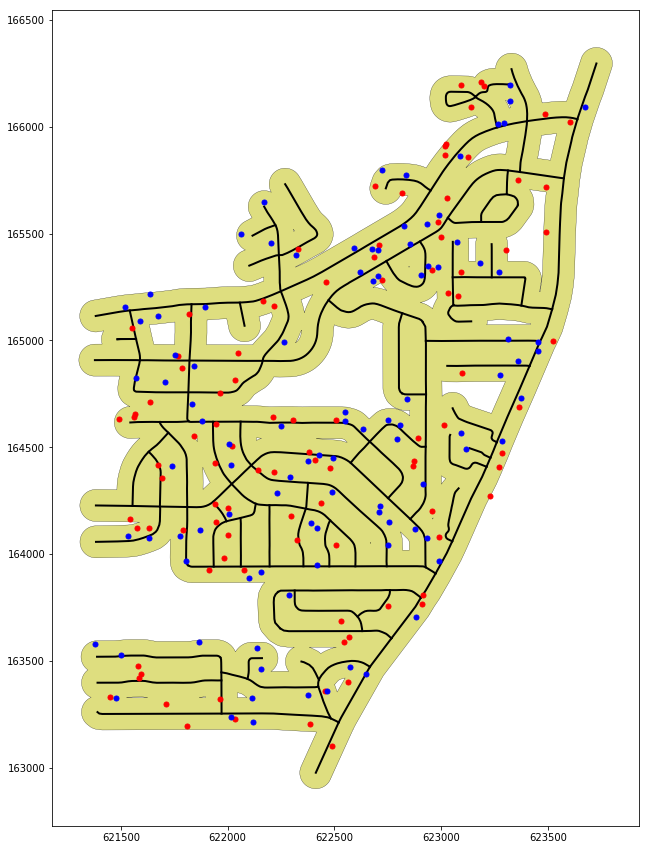

In [105]:
base = streets_buffer.plot(cmap=ListedColormap('y'),
                 linewidth=.25,
                 alpha=.5)
geo_W.plot(ax=base,
           linewidth=2,
           cmap=ListedColormap('k'))
simulated_supply_nodes.plot(ax=base,
                            markersize=5,
                            cmap=ListedColormap('red'))
simulated_demand_nodes.plot(ax=base,
                            markersize=5,
                            cmap=ListedColormap('blue'))

In [106]:
# Snap, Create frames of points, and visualize connections
ntw_W.snapobservations(data_path_out+'simulated_supply_nodes.shp', 
                       'supply', attribute=True)
ntw_W.snapobservations(data_path_out+'simulated_demand_nodes.shp', 
                       'demand', attribute=True)
snapped_supply_list = [Point(j[0], j[1])\
                       for i,j in ntw_W.pointpatterns['supply'].snapped_coordinates.iteritems()]
snapped_supply = gpd.GeoDataFrame(snapped_supply_list, columns=["geometry"])
snapped_demand_list = [Point(j[0], j[1])\
                       for i,j in ntw_W.pointpatterns['demand'].snapped_coordinates.iteritems()]
snapped_demand = gpd.GeoDataFrame(snapped_demand_list, columns=["geometry"])
r_supply = range(supply_nodes_needed)
supply_connectors = [LineString((snapped_supply.geometry[p],simulated_supply_nodes.geometry[p]))\
                     for p in r_demand]
supply_connectors = gpd.GeoDataFrame(supply_connectors, columns=["geometry"])
r_demand = range(demand_nodes_needed)
demand_connectors = [LineString((snapped_demand.geometry[p], simulated_demand_nodes.geometry[p]))\
                     for p in r_demand]
demand_connectors = gpd.GeoDataFrame(demand_connectors, columns=["geometry"])

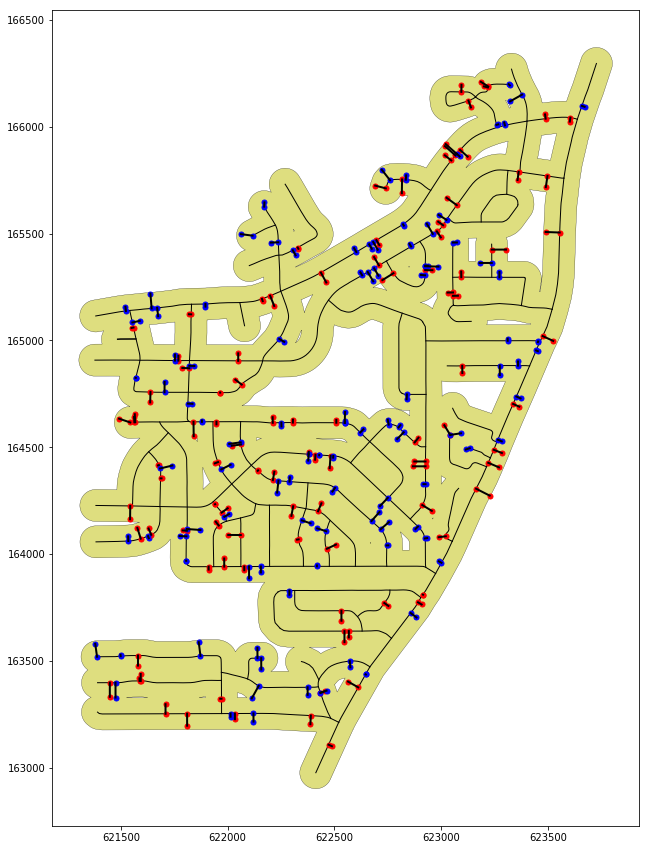

In [107]:
base = streets_buffer.plot(cmap=ListedColormap('y'),
                 linewidth=.25,
                 alpha=.5)
geo_W.plot(ax=base,
           linewidth=1,
           cmap=ListedColormap('k'))
simulated_supply_nodes.plot(ax=base,
                            markersize=5,
                            cmap=ListedColormap('red'))
simulated_demand_nodes.plot(ax=base,
                            markersize=5,
                            cmap=ListedColormap('blue'))
snapped_supply.plot(ax=base,
                            markersize=5,
                            cmap=ListedColormap('red'))
snapped_demand.plot(ax=base,
                            markersize=5,
                            cmap=ListedColormap('blue'))
supply_connectors.plot(ax=base,
                       linewidth=2,
                       cmap=ListedColormap('k'))
demand_connectors.plot(ax=base,
                       linewidth=2,
                       cmap=ListedColormap('k'))

In [124]:
All_Neigh_Dist = ntw_W.allneighbordistances(sourcepattern=ntw_W.pointpatterns['supply'],
                                            destpattern=ntw_W.pointpatterns['demand']) # in meters
All_Dist_MILES = All_Neigh_Dist * 0.000621371 # to miles

In [133]:
sv, cm, rt = transportation_simplex(len(All_Dist_MILES), len(All_Dist_MILES[0]), seed=2,
                                    relaxed=True,
                                    costmatrix=All_Dist_MILES,
                                    simulated_sd="lowhigh",
                                    name="TransportationProblem",
                                    output=1,
                                    mipfocus=2,
                                    method=methods["primal simplex"],
                                    timelimit=1)
solution_info(sv, cm, rt)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 4  Default: -1
Changed value of parameter TimeLimit to 1.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100


/Users/jgaboardi/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:97: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Optimize a model with 200 rows, 10000 columns and 20000 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve time: 0.02s
Presolved: 200 rows, 10000 columns, 20000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.270000e+03   9.999988e+09      0s
    1104    6.2867487e+02   0.000000e+00   0.000000e+00      0s

Solved in 1104 iterations and 0.05 seconds
Optimal objective  6.286748701e+02
*************************************************************
Cost Matrix Size (GB):			7.46101140976e-05
Real Time Build & Solve (sec):		0.00985716666667
*************************************************************
  Decision_Variable_Name  Decision_Variable_Value
0                sd[0,0]                     32.0
1               sd[0,71]                     17.0
2               sd[0,87]                     23.0
3              

/Users/jgaboardi/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


----------------

# $ \text{RAM Disparity: Numpy array vs. Dask array} $

In [135]:
dimensions = 500
dimensions_range = range(2,dimensions,50)
numpy_arrays = [np.zeros([d,d]) for d in dimensions_range]
array_range = range(len(numpy_arrays))
dask_arrays = [da.from_array(numpy_arrays[array], chunks=array+1) for array in array_range]
size_dataframe = pd.DataFrame()
size_dataframe["Dimensions"] = dimensions_range
size_dataframe["Numpy"] = [sys.getsizeof(numpy_arrays[array])*GB for array in array_range]
size_dataframe["Dask"] = [sys.getsizeof(dask_arrays[array])*GB for array in array_range]
size_dataframe.head()

,Dimensions,Numpy,Dask
0,2,1.546188e+11,1.030792e+11
1,52,2.334744e+13,1.030792e+11
2,102,8.948994e+13,1.030792e+11
3,152,1.985821e+14,1.030792e+11
4,202,3.506240e+14,1.030792e+11


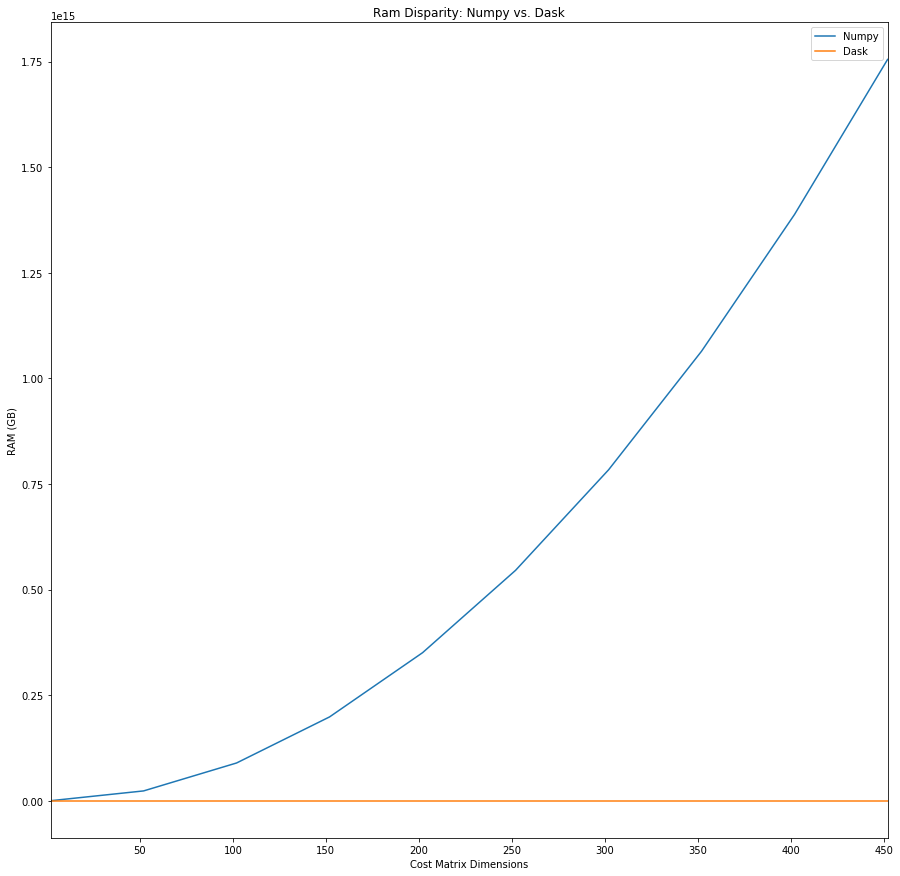

In [136]:
base = size_dataframe.plot("Dimensions", "Numpy")
size_dataframe.plot("Dimensions", "Dask", ax=base)
base.set_title("Ram Disparity: Numpy vs. Dask")
base.set_xlabel('Cost Matrix Dimensions')
base.set_ylabel('RAM (GB)')

# $ \text{Into the future:} $

* $\text{RAM Disparity: Numpy array vs. Dask array}$

### This 4,000 x 4,000 solves in around 25 minutes on my laptop and eats up all the available RAM (16GB total).

# $ \text{System Specs}$

In [55]:
spec_index = ['Python version', 'Python compiler', 'Gurobi version', 'PuLP version',\
              'NumPy version', 'Pandas version', 'Dask version', 'GeoPandas version',\
              'PySAl version', 'Platform', \
              'Cores available', 'CPU Time %']
spec_info = [platform.python_version(), platform.python_compiler(),\
             grb.gurobi.version(), pulp.VERSION,
             np.__version__, pd.__version__, dask.__version__,\
             gpd.__version__, ps.version,
             platform.platform(), psutil.cpu_count(),\
             psutil.cpu_times_percent(),]
system_specs = pd.DataFrame(index=spec_index)
system_specs['System & Version Specs'] = spec_info
system_specs

,System & Version Specs
Python version,2.7.13
Python compiler,GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-6...
Gurobi version,"(7, 0, 2)"
PuLP version,1.6.5
NumPy version,1.12.1
Pandas version,0.19.2
Dask version,0.14.1
GeoPandas version,0.2.1
PySAl version,1.13.0
Platform,Darwin-16.5.0-x86_64-i386-64bit


## $ \text{email } \Longrightarrow \text{ jgaboardi@fsu.edu} $
## $ \text{GitHub } \Longrightarrow \text{https://github.com/jGaboardi/AAG_17} $

In [ ]:
IPd.HTML('https://github.com/jGaboardi')

----